## GOOGLE OR INCEPTION NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


2.15.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 4326 images belonging to 12 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1200 images belonging to 12 classes.


In [5]:
def googlenet(input_shape, n_classes):
  
  def inception_block(x, f):
    t1 = Conv2D(f[0], 1, activation='relu')(x)
    
    t2 = Conv2D(f[1], 1, activation='relu')(x)
    t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
    
    t3 = Conv2D(f[3], 1, activation='relu')(x)
    t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
    
    t4 = MaxPool2D(3, 1, padding='same')(x)
    t4 = Conv2D(f[5], 1, activation='relu')(t4)
    
    output = Concatenate()([t1, t2, t3, t4])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = Conv2D(64, 1, activation='relu')(x)
  x = Conv2D(192, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = inception_block(x, [64, 96, 128, 16, 32, 32])
  x = inception_block(x, [128, 128, 192, 32, 96, 64])
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = inception_block(x, [192, 96, 208, 16, 48, 64])
  x = inception_block(x, [160, 112, 224, 24, 64, 64])
  x = inception_block(x, [128, 128, 256, 24, 64, 64])
  x = inception_block(x, [112, 144, 288, 32, 64, 64])
  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
  x = AvgPool2D(7, strides=1)(x)
  x = Dropout(0.4)(x)
  
  x = Flatten()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 12

K.clear_session()
model = googlenet(input_shape, n_classes)
model.summary() 




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 64)           4160      ['max_pooling2d[0][0]']

 conv2d_49 (Conv2D)             (None, 7, 7, 128)    102528      ['conv2d_48[0][0]']              
                                                                                                  
 conv2d_50 (Conv2D)             (None, 7, 7, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 7, 7, 832)    0           ['conv2d_45[0][0]',              
                                                                  'conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 7, 7, 192)    159936      ['concatenate_7[0][0]']          
          

In [6]:
model_path = "GOOGLE.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 50
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/50


8/8 [==============================] - ETA: 0s - loss: 2.4907 - accuracy: 0.1133 - precision: 0.0000e+00
Epoch 1: accuracy improved from -inf to 0.11328, saving model to GOOGLE.h5
8/8 [==============================] - 60s 4s/step - loss: 2.4907 - accuracy: 0.1133 - precision: 0.0000e+00 - val_loss: 2.5040 - val_accuracy: 0.0781 - val_precision: 0.0000e+00
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 2.4913 - accuracy: 0.0781 - precision: 0.0000e+00
Epoch 2: accuracy did not improve from 0.11328
8/8 [==============================] - 28s 3s/step - loss: 2.4913 - accuracy: 0.0781 - precision: 0.0000e+00 - val_loss: 2.4889 - val_accuracy: 0.0312 - val_precision: 0.0000e+00
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 2.4861 - accuracy: 0.0664 - precision: 0.0000e+00
Epoch 3: accuracy did not improve from 0.11328
8/8 [==============================] - 28s 3s/step - loss: 2.4861 - accuracy: 0.0664 - precision: 0.0000e+00 - val_loss: 2.

Epoch 49/50
3/3 [==============================] - ETA: 0s - loss: 1.3839 - accuracy: 0.2917 - precision: 0.0000e+00
Epoch 49: accuracy did not improve from 0.34375
3/3 [==============================] - 20s 7s/step - loss: 1.3839 - accuracy: 0.2917 - precision: 0.0000e+00 - val_loss: 1.3877 - val_accuracy: 0.2604 - val_precision: 0.0000e+00
Epoch 50/50
3/3 [==============================] - ETA: 0s - loss: 1.3861 - accuracy: 0.2500 - precision: 0.0000e+00
Epoch 50: accuracy did not improve from 0.34375
3/3 [==============================] - 21s 7s/step - loss: 1.3861 - accuracy: 0.2500 - precision: 0.0000e+00 - val_loss: 1.3888 - val_accuracy: 0.2396 - val_precision: 0.0000e+00


In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

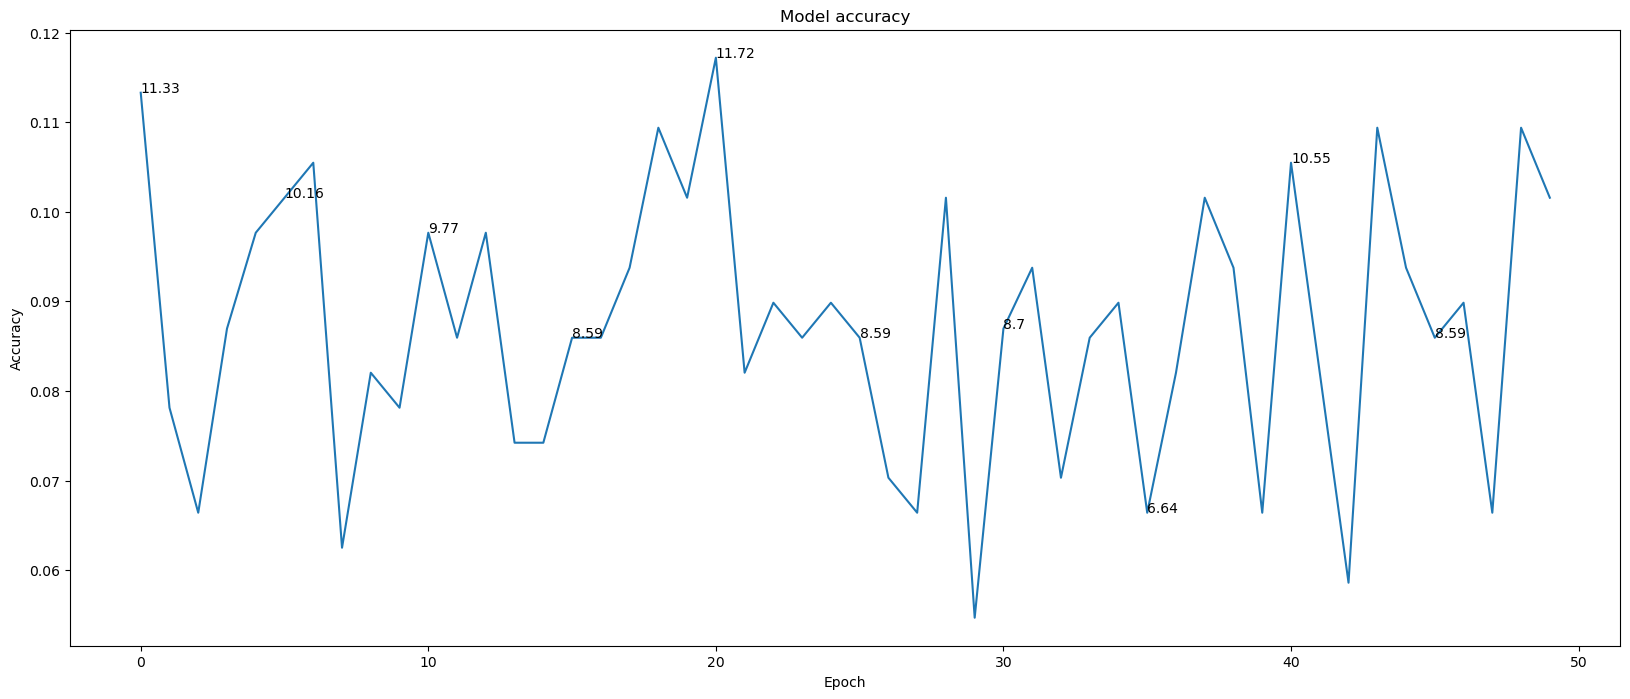

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

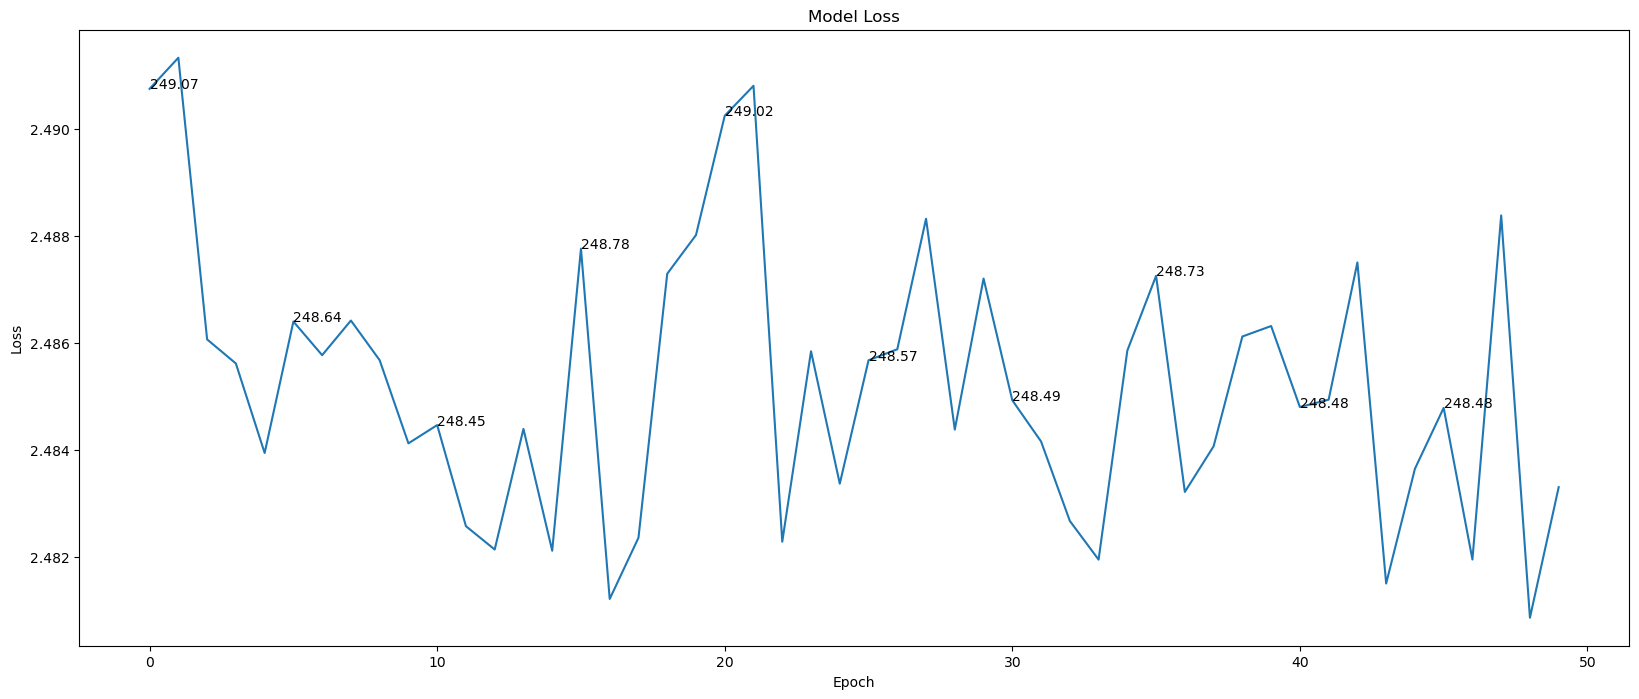

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()